In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve

In [3]:
N = 50  # Number of grid points in each direction (N x N grid)
L = 1.0 # Domain size [0, L] x [0, L]
h = L / (N - 1) 
a = 1.0
b = 2.0

print(f"Total nodes: {N*N}")
print(f"Step size h: {h}")


Total nodes: 2500
Step size h: 0.02040816326530612


In [4]:
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

N_internal = N - 2
total_internal_nodes = N_internal * N_internal

In [5]:
def source_term(x, y, a, b):
    return x * np.sin(a * np.pi * y) + y * np.sin(b * np.pi * x)

f = np.zeros((N_internal, N_internal))
for i in range(N_internal):
    for j in range(N_internal):
        x_coord = x[i + 1] # x coordinates skip the 0 boundary
        y_coord = y[j + 1] # y coordinates skip the 0 boundary
        f[i, j] = source_term(x_coord, y_coord, a, b)

# Flatten f into a vector for the linear system Ax = f_vec
f_vec = f.flatten()

In [6]:
# Use List of Lists format for efficient sparse matrix construction
A = lil_matrix((total_internal_nodes, total_internal_nodes))

# Fill the matrix based on the 5-point stencil
for i in range(N_internal): # Corresponds to x index
    for j in range(N_internal): # Corresponds to y index
        row_idx = i * N_internal + j # Global index for node (i, j)

        # Diagonal element (4 * u_ij)
        A[row_idx, row_idx] = 4

        # Off-diagonal elements (-1 * neighbors)
        if i > 0: # Neighbor (i-1, j)
            A[row_idx, (i - 1) * N_internal + j] = -1
        if i < N_internal - 1: # Neighbor (i+1, j)
            A[row_idx, (i + 1) * N_internal + j] = -1
        if j > 0: # Neighbor (i, j-1)
            A[row_idx, i * N_internal + (j - 1)] = -1
        if j < N_internal - 1: # Neighbor (i, j+1)
            A[row_idx, i * N_internal + (j + 1)] = -1

# Scale by 1/h^2
A = A / (h**2)

# Convert to Compressed Sparse Column format for efficient solving
A_csc = A.tocsc()

print(f"Matrix A shape: {A_csc.shape}")

Matrix A shape: (2304, 2304)


In [7]:
# Solve A * u_vec = f_vec for the interior solution u_vec
u_vec = spsolve(A_csc, f_vec)

print("Linear system solved.")

Linear system solved.


In [8]:
# Reshape the flat vector u_vec back into a 2D grid for the interior
u_internal = u_vec.reshape((N_internal, N_internal))

# Create the full solution grid (N x N) and fill with zeros
u_full = np.zeros((N, N))

# Insert the calculated interior solution
u_full[1:-1, 1:-1] = u_internal

# The boundaries remain 0 as per the problem definition [cite: 1]

print("Full solution grid created.")

Full solution grid created.


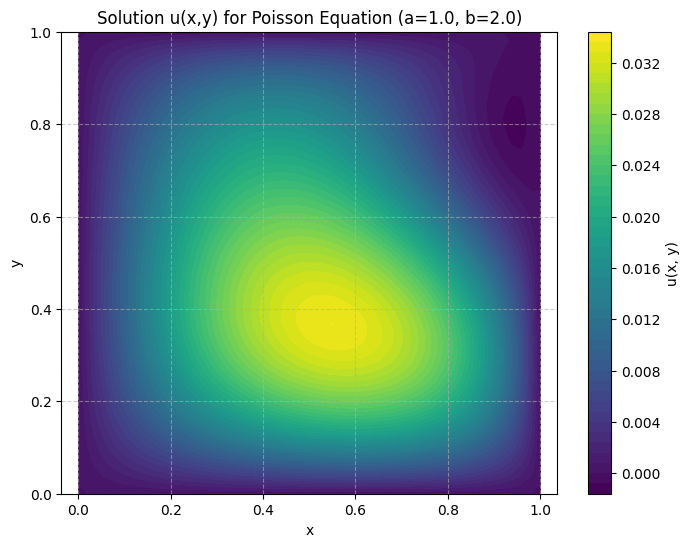

In [9]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, u_full, 50, cmap='viridis') # Use contourf for filled contours
plt.colorbar(contour, label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Solution u(x,y) for Poisson Equation (a={a}, b={b})')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f'figure_solution_exemple.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Define Problem Parameters (Use values from Cell 2) ---
N_domain = 100 # Number of points for PDE residual sampling inside domain
N_boundary = 100 # Number of points on each boundary edge
L = 1.0
a = 1.0 # Fixed a for this PINN instance
b = 2.0 # Fixed b for this PINN instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Source term function (using torch for potential grad)
def source_term_torch(x, y, a, b):
    return x * torch.sin(a * torch.pi * y) + y * torch.sin(b * torch.pi * x)

# --- Define PINN Model ---
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, y):
        input_tensor = torch.cat([x, y], dim=1)
        return self.net(input_tensor)

# --- Define Loss Function ---
def pinn_loss(model, x_domain, y_domain, x_bc, y_bc, a_val, b_val):
    # PDE Residual Loss (Interior Points)
    x_domain.requires_grad_(True)
    y_domain.requires_grad_(True)
    u_domain = model(x_domain, y_domain)

    u_x = torch.autograd.grad(u_domain, x_domain, grad_outputs=torch.ones_like(u_domain), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_domain, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u_domain, y_domain, grad_outputs=torch.ones_like(u_domain), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_domain, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    laplacian_u = u_xx + u_yy
    f_values = source_term_torch(x_domain, y_domain, a_val, b_val)
    pde_residual = -laplacian_u - f_values # PDE: -Laplacian(u) = f
    loss_pde = torch.mean(pde_residual**2)

    # Boundary Condition Loss (Dirichlet u=0)
    u_bc = model(x_bc, y_bc)
    loss_bc = torch.mean(u_bc**2) # Target is 0

    # Combine losses (can add weighting factors if needed)
    total_loss = loss_pde + 10.0 * loss_bc # Example weighting
    return total_loss, loss_pde, loss_bc

# --- Prepare Data Points ---
# Domain points (excluding boundary for residual calculation)
x_domain_np = np.random.rand(N_domain, 1) * L
y_domain_np = np.random.rand(N_domain, 1) * L
x_domain_t = torch.tensor(x_domain_np, dtype=torch.float32).to(device)
y_domain_t = torch.tensor(y_domain_np, dtype=torch.float32).to(device)

# Boundary points (Dirichlet u=0)
x_bc_left = torch.zeros((N_boundary, 1), dtype=torch.float32)
y_bc_left = torch.rand((N_boundary, 1), dtype=torch.float32) * L
x_bc_right = torch.ones((N_boundary, 1), dtype=torch.float32) * L
y_bc_right = torch.rand((N_boundary, 1), dtype=torch.float32) * L
x_bc_bottom = torch.rand((N_boundary, 1), dtype=torch.float32) * L
y_bc_bottom = torch.zeros((N_boundary, 1), dtype=torch.float32)
x_bc_top = torch.rand((N_boundary, 1), dtype=torch.float32) * L
y_bc_top = torch.ones((N_boundary, 1), dtype=torch.float32) * L

x_bc_t = torch.cat([x_bc_left, x_bc_right, x_bc_bottom, x_bc_top], dim=0).to(device)
y_bc_t = torch.cat([y_bc_left, y_bc_right, y_bc_bottom, y_bc_top], dim=0).to(device)

# --- Instantiate Model and Optimizer ---
model_pinn = PINN().to(device)
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=1e-3)
print(model_pinn)
print(f"PINN Model moved to device: {device}")

# --- Training Loop ---
epochs_pinn = 10000 # PINNs often require more epochs
start_time_pinn = time.time()

for epoch in range(epochs_pinn):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    loss, loss_pde, loss_bc = pinn_loss(model_pinn, x_domain_t, y_domain_t, x_bc_t, y_bc_t, a, b)

    loss.backward()
    optimizer_pinn.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs_pinn}], Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, BC Loss: {loss_bc.item():.6f}")

end_time_pinn = time.time()
print(f"PINN Training finished. Time taken: {end_time_pinn - start_time_pinn:.2f} seconds")

# --- Evaluation (Optional: Plot PINN solution) ---
model_pinn.eval()
N_eval = 100 # Grid for plotting
x_plot = np.linspace(0, L, N_eval)
y_plot = np.linspace(0, L, N_eval)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_flat = torch.tensor(X_plot.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
Y_flat = torch.tensor(Y_plot.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    U_pinn_flat = model_pinn(X_flat, Y_flat)

U_pinn = U_pinn_flat.cpu().numpy().reshape((N_eval, N_eval))

plt.figure(figsize=(8, 6))
contour = plt.contourf(X_plot, Y_plot, U_pinn, 50, cmap='viridis')
plt.colorbar(contour, label='u_PINN(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'PINN Solution u(x,y) for Poisson Equation (a={a}, b={b})')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('figure_solution_pinn.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Calculate Final PDE Residual (as in notebook cell 12) ---
# Use a denser grid for residual evaluation
N_pde_eval = 100 # e.g., 100x100 grid for evaluation
x_pde_eval_np = np.linspace(h/2, L-h/2, N_pde_eval) # Interior points
y_pde_eval_np = np.linspace(h/2, L-h/2, N_pde_eval)
X_pde_eval_np, Y_pde_eval_np = np.meshgrid(x_pde_eval_np, y_pde_eval_np)
X_pde_t = torch.tensor(X_pde_eval_np.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
Y_pde_t = torch.tensor(Y_pde_eval_np.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

X_pde_t.requires_grad_(True)
Y_pde_t.requires_grad_(True)

model_pinn.eval() # Ensure model is in eval mode
u_pde = model_pinn(X_pde_t, Y_pde_t)

# Calculate gradients for the Laplacian
u_x = torch.autograd.grad(u_pde, X_pde_t, grad_outputs=torch.ones_like(u_pde), create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, X_pde_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
u_y = torch.autograd.grad(u_pde, Y_pde_t, grad_outputs=torch.ones_like(u_pde), create_graph=True)[0]
u_yy = torch.autograd.grad(u_y, Y_pde_t, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

laplacian_u_values = u_xx + u_yy
f_values_eval = source_term_torch(X_pde_t, Y_pde_t, a, b)

# Calculate PDE residual R = -nabla^2 u - f
residual_pde_values = -laplacian_u_values - f_values_eval

# Calculate final residual metrics
final_loss_pde_mse = torch.mean(residual_pde_values**2)
final_loss_pde_mae = torch.mean(torch.abs(residual_pde_values))
final_loss_pde_rms = torch.sqrt(final_loss_pde_mse)

# Detach for printing
final_loss_pde_mse_item = final_loss_pde_mse.item()
final_loss_pde_mae_item = final_loss_pde_mae.item()
final_loss_pde_rms_item = final_loss_pde_rms.item()

print(f"\nPINN Final PDE Residual Metrics (evaluated on {N_pde_eval*N_pde_eval} interior points):")
print(f"  MSE Residual: {final_loss_pde_mse_item:.6f}")
print(f"  MAE Residual:            {final_loss_pde_mae_item:.6f}")
print(f"  RMS Residual (sqrt(MSE)):{final_loss_pde_rms_item:.6f}")

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)
PINN Model moved to device: cuda


c:\Users\Vikos\anaconda3\envs\graph_gpu_env\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Using device: cuda
Pre-computed matrix A (CSC format)
Train dataset size: 80
Validation dataset size: 20
GNN_PoissonSolver(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 1)
)
Starting GNN training...


C:\Users\Vikos\AppData\Local\Temp\ipykernel_39104\4145105973.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{idx

Epoch [1/100], Train Loss: 0.013004, Val Loss: 0.004525
Epoch [2/100], Train Loss: 0.004770, Val Loss: 0.003685
Epoch [3/100], Train Loss: 0.001948, Val Loss: 0.000774
Epoch [4/100], Train Loss: 0.001464, Val Loss: 0.001732
Epoch [5/100], Train Loss: 0.001493, Val Loss: 0.000586
Epoch [6/100], Train Loss: 0.000673, Val Loss: 0.000557
Epoch [7/100], Train Loss: 0.000695, Val Loss: 0.000417
Epoch [8/100], Train Loss: 0.000529, Val Loss: 0.000214
Epoch [9/100], Train Loss: 0.000524, Val Loss: 0.000196
Epoch [10/100], Train Loss: 0.000451, Val Loss: 0.000202
Epoch [11/100], Train Loss: 0.000415, Val Loss: 0.000244
Epoch [12/100], Train Loss: 0.000402, Val Loss: 0.000188
Epoch [13/100], Train Loss: 0.000380, Val Loss: 0.000165
Epoch [14/100], Train Loss: 0.000365, Val Loss: 0.000167
Epoch [15/100], Train Loss: 0.000362, Val Loss: 0.000184
Epoch [16/100], Train Loss: 0.000350, Val Loss: 0.000157
Epoch [17/100], Train Loss: 0.000331, Val Loss: 0.000145
Epoch [18/100], Train Loss: 0.000321, Va

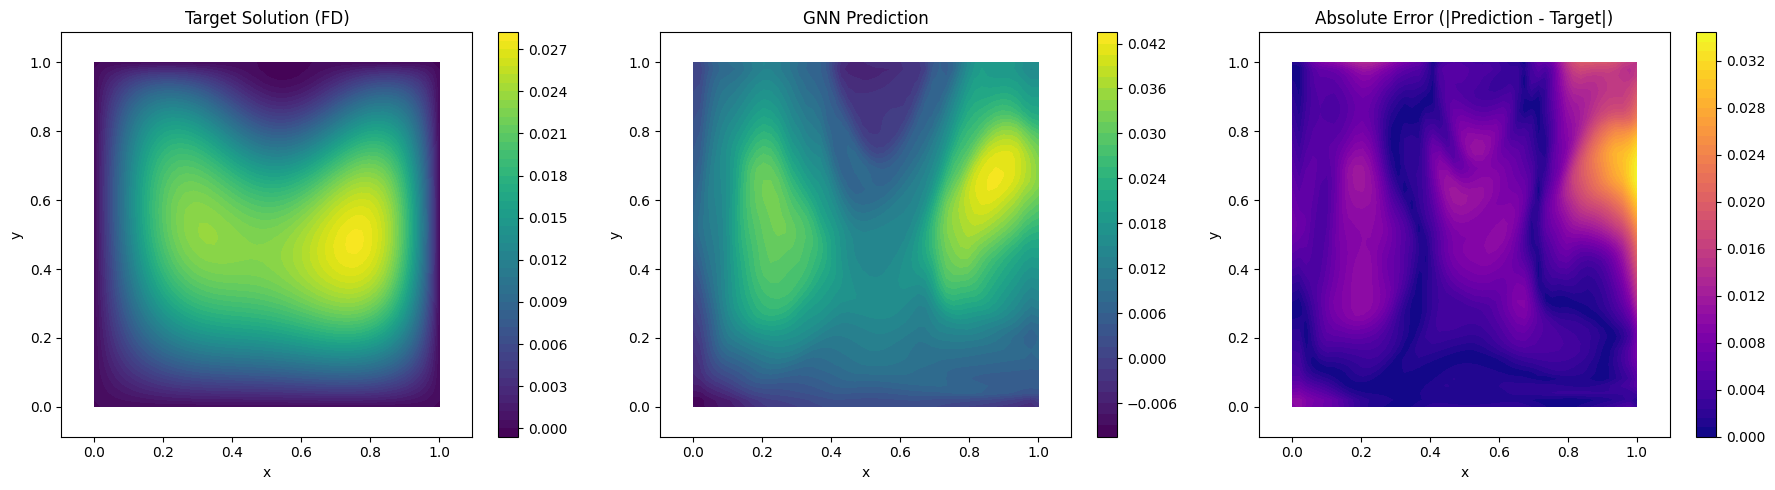

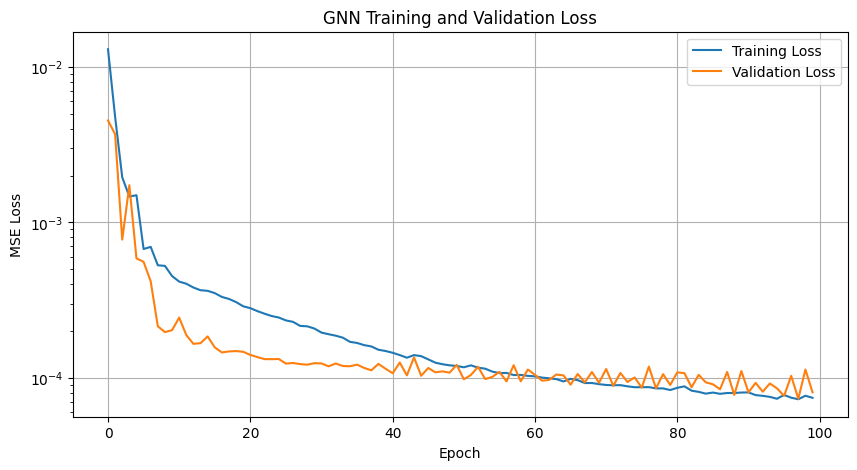

In [ ]:
# --- Imports ---
import numpy as np
import time
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, MessagePassing # Example: using GCNConv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Finite Difference Solver & Data Generation Setup (from project.ipynb) ---
N = 50  # Grid size (Keep consistent)
L = 1.0
h = L / (N - 1)
x_np = np.linspace(0, L, N)
y_np = np.linspace(0, L, N)
X_np, Y_np = np.meshgrid(x_np, y_np)
N_internal = N - 2
total_internal_nodes = N_internal * N_internal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def source_term(x, y, a, b):
    return x * np.sin(a * np.pi * y) + y * np.sin(b * np.pi * x)

# Pre-compute sparse matrix A if N is constant
A = lil_matrix((total_internal_nodes, total_internal_nodes))
# (Matrix A construction loop - same as in previous codes)
for i in range(N_internal):
    for j in range(N_internal):
        row_idx = i * N_internal + j
        A[row_idx, row_idx] = 4
        if i > 0: A[row_idx, (i - 1) * N_internal + j] = -1
        if i < N_internal - 1: A[row_idx, (i + 1) * N_internal + j] = -1
        if j > 0: A[row_idx, i * N_internal + (j - 1)] = -1
        if j < N_internal - 1: A[row_idx, i * N_internal + (j + 1)] = -1
A = A / (h**2)
A_csc = A.tocsc()
print("Pre-computed matrix A (CSC format)")

def solve_poisson_for_ab(a_val, b_val, N=50):
    # Source term calculation (on internal nodes)
    f_internal = np.zeros((N_internal, N_internal))
    for i in range(N_internal):
        for j in range(N_internal):
            x_coord = x_np[i + 1]
            y_coord = y_np[j + 1]
            f_internal[i, j] = source_term(x_coord, y_coord, a_val, b_val)
    f_vec = f_internal.flatten()

    # Solve using pre-computed A_csc
    u_vec = spsolve(A_csc, f_vec)

    # Reshape and embed in full grid (with boundaries)
    u_internal = u_vec.reshape((N_internal, N_internal))
    u_full = np.zeros((N, N))
    u_full[1:-1, 1:-1] = u_internal

    # Also compute source term on the full grid for GNN input
    f_full = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
             f_full[i, j] = source_term(x_np[i], y_np[j], a_val, b_val)

    return u_full, f_full # Return both solution and full source term grid

# --- Graph Conversion ---
def grid_to_graph(u_solution, f_source, N, h):
    """Converts a simulation result on an NxN grid to a PyG Data object."""
    num_nodes = N * N
    x_coords = X_np.flatten()
    y_coords = Y_np.flatten()
    f_values = f_source.flatten()
    u_values = u_solution.flatten() # This will be the target 'y'

    # Node features: [x_coord, y_coord, f_value]
    node_features = torch.tensor(np.stack([x_coords, y_coords, f_values], axis=-1), dtype=torch.float32)

    # Edges: Connect adjacent nodes (4-connectivity)
    edge_list = []
    for i in range(N):
        for j in range(N):
            node_idx = i * N + j
            # Connect to right neighbor
            if j < N - 1:
                neighbor_idx = i * N + (j + 1)
                edge_list.append([node_idx, neighbor_idx])
                edge_list.append([neighbor_idx, node_idx]) # Add reverse edge for undirected graph
            # Connect to bottom neighbor
            if i < N - 1:
                neighbor_idx = (i + 1) * N + j
                edge_list.append([node_idx, neighbor_idx])
                edge_list.append([neighbor_idx, node_idx])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    # Target values for nodes (the solution u)
    y = torch.tensor(u_values, dtype=torch.float32).unsqueeze(1) # Shape [num_nodes, 1]

    return Data(x=node_features, edge_index=edge_index, y=y)

# --- Create Graph Dataset ---
class PoissonGraphDataset(Dataset):
    def __init__(self, root, num_simulations=100, N=50, transform=None, pre_transform=None):
        self.num_simulations = num_simulations
        self.N = N
        self.L = 1.0
        self.h = self.L / (self.N - 1)
        # Parameters for source term variability
        self.a_values = np.linspace(0.5, 3.0, int(np.sqrt(num_simulations)))
        self.b_values = np.linspace(0.5, 3.0, int(np.sqrt(num_simulations)))
        super(PoissonGraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        # Indicate that raw files don't need to be downloaded/found
        return []

    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(self.num_simulations)]

    def download(self):
        # Raw data is generated on the fly if needed
        pass

    def process(self):
        idx = 0
        print("Generating and processing graph data...")
        start_time = time.time()
        for a_val in self.a_values:
            for b_val in self.b_values:
                if idx >= self.num_simulations: break
                # Solve PDE
                u_solution, f_source = solve_poisson_for_ab(a_val, b_val, N=self.N)
                # Convert to graph
                data = grid_to_graph(u_solution, f_source, self.N, self.h)

                if self.pre_filter is not None and not self.pre_filter(data):
                    continue
                if self.pre_transform is not None:
                    data = self.pre_transform(data)

                torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
                idx += 1
                if idx % 10 == 0 or idx == self.num_simulations:
                    print(f"Processed {idx}/{self.num_simulations} graphs...")
            if idx >= self.num_simulations: break
        end_time = time.time()
        print(f"Dataset processing finished. Time: {end_time - start_time:.2f} s")

    def len(self):
        return self.num_simulations

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# --- Define GNN Model ---
class GNN_PoissonSolver(torch.nn.Module):
    def __init__(self, node_features_in=3, node_features_hidden=64, node_features_out=1):
        super(GNN_PoissonSolver, self).__init__()
        self.conv1 = GCNConv(node_features_in, node_features_hidden)
        self.conv2 = GCNConv(node_features_hidden, node_features_hidden)
        self.conv3 = GCNConv(node_features_hidden, node_features_out) # Output is scalar u value

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training) # Optional dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index) # Output layer
        return x

# --- Prepare Dataset and Dataloaders ---
import os.path as osp

# Create/load dataset (specify a root directory)
dataset_root = './poisson_gnn_dataset'
dataset = PoissonGraphDataset(root=dataset_root, num_simulations=100, N=N) # Match N

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size_gnn = 16 # Process multiple graphs in a batch
train_loader_gnn = DataLoader(train_dataset, batch_size=batch_size_gnn, shuffle=True)
val_loader_gnn = DataLoader(val_dataset, batch_size=batch_size_gnn, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# --- Instantiate Model, Loss, Optimizer ---
model_gnn = GNN_PoissonSolver(node_features_in=3, node_features_hidden=64, node_features_out=1).to(device)
optimizer_gnn = torch.optim.Adam(model_gnn.parameters(), lr=0.001)
criterion_gnn = torch.nn.MSELoss() # Mean Squared Error between predicted u and FD u
print(model_gnn)

# --- Training Loop ---
epochs_gnn = 100
train_losses_gnn = []
val_losses_gnn = []

print("Starting GNN training...")
for epoch in range(epochs_gnn):
    model_gnn.train()
    running_train_loss = 0.0
    for batch in train_loader_gnn:
        batch = batch.to(device) # Move batch of graphs to device
        optimizer_gnn.zero_grad()
        out = model_gnn(batch)
        loss = criterion_gnn(out, batch.y) # Compare output u with target u (batch.y)
        loss.backward()
        optimizer_gnn.step()
        running_train_loss += loss.item() * batch.num_graphs # Accumulate loss scaled by batch size

    epoch_train_loss = running_train_loss / len(train_loader_gnn.dataset)
    train_losses_gnn.append(epoch_train_loss)

    # Validation
    model_gnn.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader_gnn:
            batch = batch.to(device)
            out = model_gnn(batch)
            loss = criterion_gnn(out, batch.y)
            running_val_loss += loss.item() * batch.num_graphs

    epoch_val_loss = running_val_loss / len(val_loader_gnn.dataset)
    val_losses_gnn.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{epochs_gnn}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

print("GNN Training finished.")

# --- Evaluate (Example: Plot prediction for one validation sample) ---
model_gnn.eval()
# Get one sample from validation set
sample_data = next(iter(val_loader_gnn)).to(device) # Get first batch
sample_graph = sample_data[0] # Get first graph from the batch

with torch.no_grad():
    prediction = model_gnn(sample_graph)

# Reshape prediction and target back to grid for plotting
u_pred_gnn = prediction.cpu().numpy().reshape((N, N))
u_target_gnn = sample_graph.y.cpu().numpy().reshape((N, N))
# Get coordinates and source term from the sample graph features
f_source_gnn = sample_graph.x[:, 2].cpu().numpy().reshape((N, N)) # Assuming f is the 3rd feature


# Calculate final validation loss (MSE and MAE)
final_val_mse = 0.0
final_val_mae = 0.0
mae_criterion = torch.nn.L1Loss()
with torch.no_grad():
    for batch in val_loader_gnn:
        batch = batch.to(device)
        out = model_gnn(batch)
        final_val_mse += criterion_gnn(out, batch.y).item() * batch.num_graphs
        final_val_mae += mae_criterion(out, batch.y).item() * batch.num_graphs

final_val_mse /= len(val_loader_gnn.dataset)
final_val_mae /= len(val_loader_gnn.dataset)

print("\nGNN Final Validation Metrics:")
print(f"  MSE: {final_val_mse:.8f}")
print(f"  MAE: {final_val_mae:.6f}")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x_plot = np.linspace(0, L, N)
y_plot = np.linspace(0, L, N)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Plot 1: Target Solution (from FD)
contour1 = axes[0].contourf(X_plot, Y_plot, u_target_gnn, 50, cmap='viridis')
fig.colorbar(contour1, ax=axes[0])
axes[0].set_title('Target Solution (FD)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].axis('equal')

# Plot 2: GNN Prediction
contour2 = axes[1].contourf(X_plot, Y_plot, u_pred_gnn, 50, cmap='viridis')
fig.colorbar(contour2, ax=axes[1])
axes[1].set_title('GNN Prediction')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].axis('equal')

# Plot 3: Absolute Error
abs_error = np.abs(u_pred_gnn - u_target_gnn)
contour3 = axes[2].contourf(X_plot, Y_plot, abs_error, 50, cmap='plasma')
fig.colorbar(contour3, ax=axes[2])
axes[2].set_title('Absolute Error (|Prediction - Target|)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].axis('equal')

plt.tight_layout()
plt.savefig('figure_solution_gnn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_gnn, label='Training Loss')
plt.plot(val_losses_gnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('GNN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.yscale('log') # Often helpful for loss plots
plt.savefig('figure_loss_gnn.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Après l'entraînement du PINN
torch.save(model_pinn, 'model_pinn.pt')

# Après l'entraînement du GNN
torch.save(model_gnn, 'model_gnn.pt')

NameError: name 'torch' is not defined

In [ ]:
def solve_poisson_for_ab(a_val, b_val, N=50):
    # --- Paste or adapt code from Cells 2-7 ---
    # Parameters
    L = 1.0
    h = L / (N - 1)
    N_internal = N - 2
    total_internal_nodes = N_internal * N_internal
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)

    # Source term
    f = np.zeros((N_internal, N_internal))
    for i in range(N_internal):
        for j in range(N_internal):
            x_coord = x[i + 1]
            y_coord = y[j + 1]
            f[i, j] = source_term(x_coord, y_coord, a_val, b_val) # Use a_val, b_val
    f_vec = f.flatten()

    # Matrix A (Construct only once if N is fixed)
    # We can optimize this later, for now, let's assume we reconstruct it
    # Or better: define A construction outside the loop if N is constant
    A = lil_matrix((total_internal_nodes, total_internal_nodes))
    for i in range(N_internal):
        for j in range(N_internal):
            row_idx = i * N_internal + j
            A[row_idx, row_idx] = 4
            if i > 0: A[row_idx, (i - 1) * N_internal + j] = -1
            if i < N_internal - 1: A[row_idx, (i + 1) * N_internal + j] = -1
            if j > 0: A[row_idx, i * N_internal + (j - 1)] = -1
            if j < N_internal - 1: A[row_idx, i * N_internal + (j + 1)] = -1
    A = A / (h**2)
    A_csc = A.tocsc()

    # Solve
    u_vec = spsolve(A_csc, f_vec)

    # Reshape
    u_internal = u_vec.reshape((N_internal, N_internal))
    u_full = np.zeros((N, N))
    u_full[1:-1, 1:-1] = u_internal
    # --- End of adapted code ---

    return u_full # Return the full solution grid


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse.linalg import spsolve

class ModelComparator:
    def __init__(self, N=50, L=1.0, a=1.0, b=2.0):
        self.N = N
        self.L = L
        self.h = L / (N - 1)
        self.a = a
        self.b = b
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def evaluate_models(self, model_pinn, model_gnn, test_data):
        """Compare PINN and GNN predictions"""
        results = {
            'pinn': {'pred': None, 'time': 0, 'mse': 0, 'mae': 0},
            'gnn': {'pred': None, 'time': 0, 'mse': 0, 'mae': 0}
        }
        
        # Évaluation PINN
        start_time = time.time()
        with torch.no_grad():
            x_eval = test_data['x_eval'].to(self.device)
            y_eval = test_data['y_eval'].to(self.device)
            pinn_pred = model_pinn(x_eval, y_eval)
        results['pinn']['time'] = time.time() - start_time
        results['pinn']['pred'] = pinn_pred.cpu().numpy().reshape((self.N, self.N))
        
        # Évaluation GNN
        start_time = time.time()
        with torch.no_grad():
            test_graph = test_data['graph'].to(self.device)
            gnn_pred = model_gnn(test_graph)
        results['pinn']['time'] = time.time() - start_time
        results['gnn']['pred'] = gnn_pred.cpu().numpy().reshape((self.N, self.N))
        
        # Calcul des métriques
        true_solution = test_data['true_solution']
        for model_type in ['pinn', 'gnn']:
            pred = results[model_type]['pred']
            results[model_type]['mse'] = np.mean((pred - true_solution)**2)
            results[model_type]['mae'] = np.mean(np.abs(pred - true_solution))
            
        return results

    def plot_comparison(self, results, save_path='comparison_plot.png'):
        """Visualise les résultats de la comparaison"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Configuration des plots
        plot_configs = [
            {'data': results['true_solution'], 'title': 'True Solution'},
            {'data': results['pinn']['pred'], 'title': 'PINN Prediction'},
            {'data': results['gnn']['pred'], 'title': 'GNN Prediction'},
            {'data': np.abs(results['pinn']['pred'] - results['true_solution']), 'title': 'PINN Error'},
            {'data': np.abs(results['gnn']['pred'] - results['true_solution']), 'title': 'GNN Error'}
        ]
        
        # Création des plots
        for idx, config in enumerate(plot_configs):
            row = idx // 3
            col = idx % 3
            im = axes[row, col].contourf(config['data'], 50, cmap='viridis')
            axes[row, col].set_title(config['title'])
            plt.colorbar(im, ax=axes[row, col])
        
        # Plot des métriques
        ax_metrics = axes[1, 2]
        metrics = [
            f"PINN MSE: {results['pinn']['mse']:.2e}",
            f"GNN MSE: {results['gnn']['mse']:.2e}",
            f"PINN MAE: {results['pinn']['mae']:.2e}",
            f"GNN MAE: {results['gnn']['mae']:.2e}",
            f"PINN Time: {results['pinn']['time']:.2f}s",
            f"GNN Time: {results['gnn']['time']:.2f}s"
        ]
        ax_metrics.text(0.1, 0.5, '\n'.join(metrics), transform=ax_metrics.transAxes)
        ax_metrics.axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

def prepare_test_case(N=50, L=1.0, a=1.0, b=2.0):
    """Prépare un cas test pour la comparaison"""
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)
    X, Y = np.meshgrid(x, y)
    
    # Solution exacte par différences finies (comme référence)
    u_fd = solve_poisson_for_ab(a, b)
    
    # Préparer les données pour PINN
    x_eval = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
    y_eval = torch.tensor(Y.flatten()[:, None], dtype=torch.float32)
    
    # Préparer les données pour GNN
    graph_data = grid_to_graph(u_fd, source_term(X, Y, a, b), N, L/N)
    
    return {
        'x_eval': x_eval,
        'y_eval': y_eval,
        'graph': graph_data,
        'true_solution': u_fd
    }

# Exemple d'utilisation
if __name__ == "__main__":
    # Paramètres
    N = 50
    L = 1.0
    a = 1.0
    b = 2.0
    
    # Créer le comparateur
    comparator = ModelComparator(N=N, L=L, a=a, b=b)
    
    # Préparer les données de test
    test_data = prepare_test_case(N=N, L=L, a=a, b=b)
    
    # Charger les modèles pré-entraînés
    model_pinn = torch.load('model_pinn.pt')
    model_gnn = torch.load('model_gnn.pt')
    
    # Évaluer les modèles
    results = comparator.evaluate_models(model_pinn, model_gnn, test_data)
    
    # Visualiser les résultats
    comparator.plot_comparison(results)